Epoch 1/50, Train Loss: 0.091323, Val Loss: 0.046470
Epoch 2/50, Train Loss: 0.015363, Val Loss: 0.000777
Epoch 3/50, Train Loss: 0.009615, Val Loss: 0.015338
Epoch 4/50, Train Loss: 0.009678, Val Loss: 0.001980
Epoch 5/50, Train Loss: 0.007592, Val Loss: 0.001187
Epoch 6/50, Train Loss: 0.006831, Val Loss: 0.006078
Epoch 7/50, Train Loss: 0.006474, Val Loss: 0.000843
Epoch 8/50, Train Loss: 0.005481, Val Loss: 0.005664
Epoch 9/50, Train Loss: 0.005011, Val Loss: 0.000994
Epoch 10/50, Train Loss: 0.004967, Val Loss: 0.000494
Epoch 11/50, Train Loss: 0.004115, Val Loss: 0.003799
Epoch 12/50, Train Loss: 0.005269, Val Loss: 0.000862
Epoch 13/50, Train Loss: 0.004029, Val Loss: 0.000566
Epoch 14/50, Train Loss: 0.003240, Val Loss: 0.000752
Epoch 15/50, Train Loss: 0.003148, Val Loss: 0.000661
Epoch 16/50, Train Loss: 0.002987, Val Loss: 0.003540
Epoch 17/50, Train Loss: 0.003323, Val Loss: 0.002618
Epoch 18/50, Train Loss: 0.003809, Val Loss: 0.001136
Epoch 19/50, Train Loss: 0.002825, Va

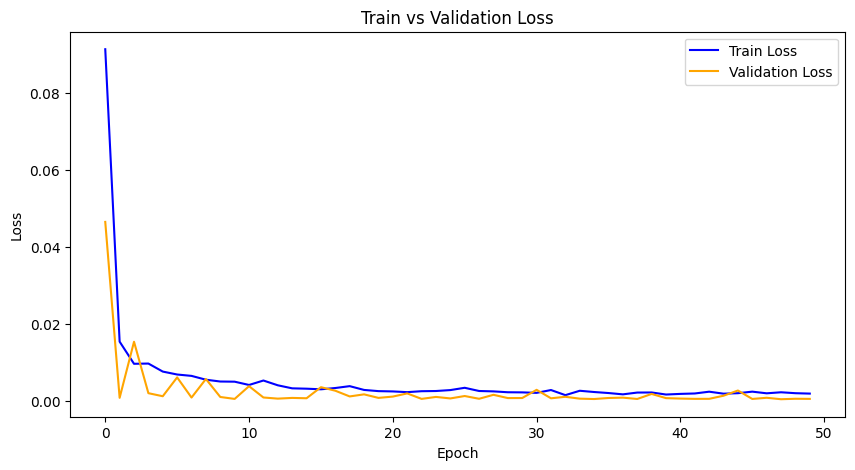

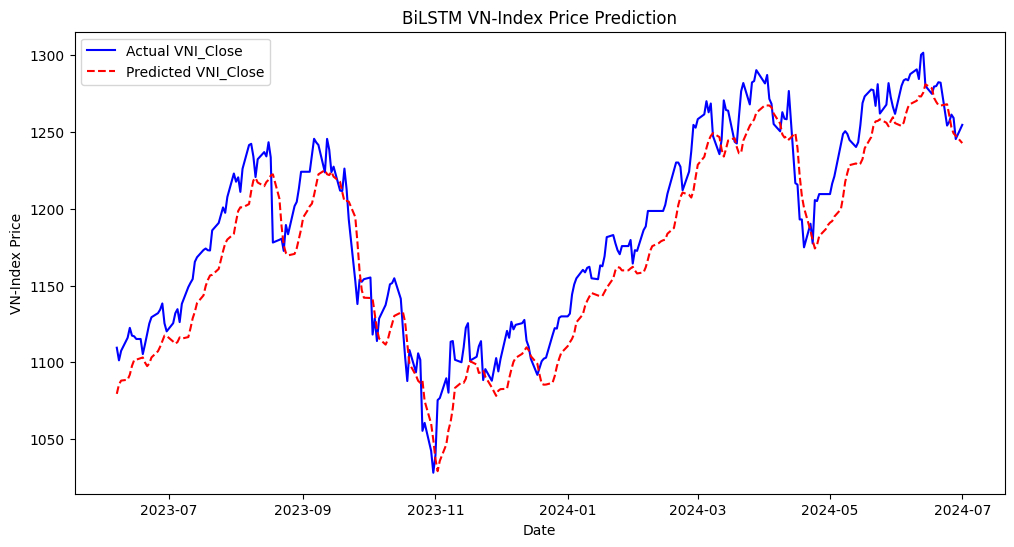

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Đọc dữ liệu
file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_base.csv"  # Cập nhật đường dẫn file
df = pd.read_csv(file_path)

# Chuyển đổi cột Date thành datetime và đặt làm index
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")
df.set_index('Date', inplace=True)

# Xác định cột mục tiêu và features
target_col = 'VNI_Close price'
feature_cols = ['VNI_Open price', 'VNI_High price', 'VNI_Low price', 'VNI_Volume']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Chia tập dữ liệu
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)

train_data = df_scaled.iloc[:train_size]
val_data = df_scaled.iloc[train_size:train_size + val_size]
test_data = df_scaled.iloc[train_size + val_size:]

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu
seq_length = 60  # Tăng từ 30 lên 60
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Tạo DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Định nghĩa mô hình BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers,
                              batch_first=True, bidirectional=True, dropout=0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        out = self.batchnorm(bilstm_out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

# Khởi tạo mô hình
input_size = X_train.shape[2]
model = BiLSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Huấn luyện mô hình
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# Lưu mô hình
torch.save(model.state_dict(), "bilstm_base.pth")
print("✅ Training hoàn tất! Mô hình đã được lưu.")

# Vẽ biểu đồ Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

# Dự đoán trên tập test
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())
        actuals.extend(batch_y.numpy())

# Chuyển về giá trị gốc
actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

# Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("BiLSTM VN-Index Price Prediction")
plt.show()

✅ Training hoàn tất! Mô hình đã được lưu.


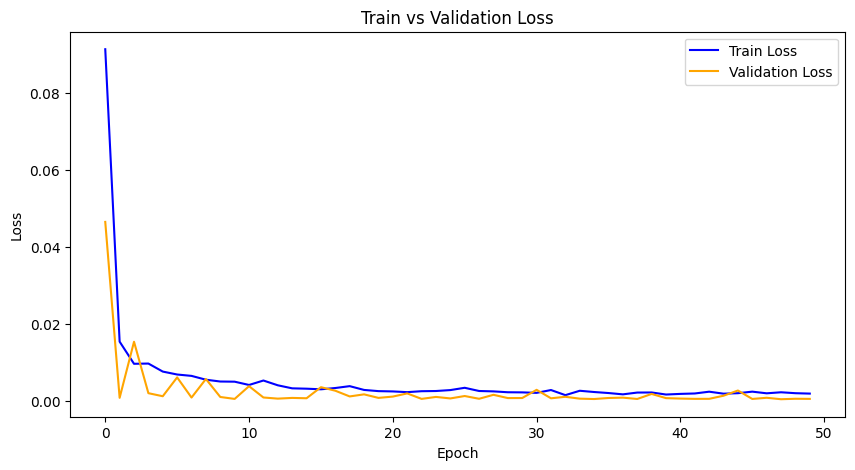

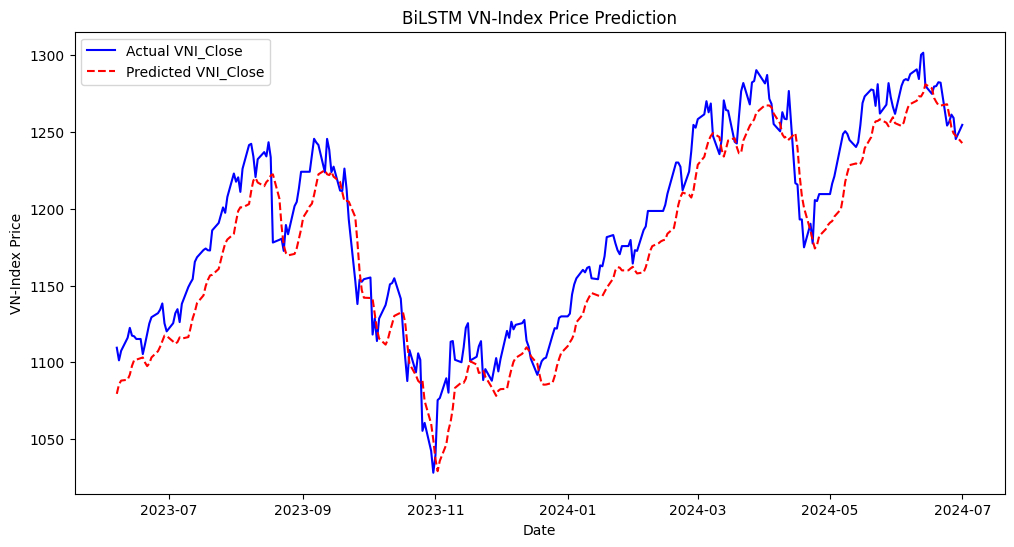

In [13]:
# Lưu mô hình
torch.save(model.state_dict(), "bilstm_base.pth")
print("✅ Training hoàn tất! Mô hình đã được lưu.")

# Vẽ biểu đồ Train vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

# Dự đoán trên tập test
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        y_pred = model(batch_X)
        predictions.extend(y_pred.cpu().numpy())
        actuals.extend(batch_y.numpy())

# Chuyển về giá trị gốc
actuals = np.array(actuals).reshape(-1, 1)
predictions = np.array(predictions).reshape(-1, 1)

scaler_target = MinMaxScaler()
scaler_target.fit(df[[target_col]])
actuals = scaler_target.inverse_transform(actuals)
predictions = scaler_target.inverse_transform(predictions)

# Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(actuals):], actuals, label="Actual VNI_Close", color='blue')
plt.plot(df.index[-len(predictions):], predictions, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.legend()
plt.title("BiLSTM VN-Index Price Prediction")
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính các chỉ số đánh giá
mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.2f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

Test MAE: 20.16
Test MSE: 521.96
Test RMSE: 22.85


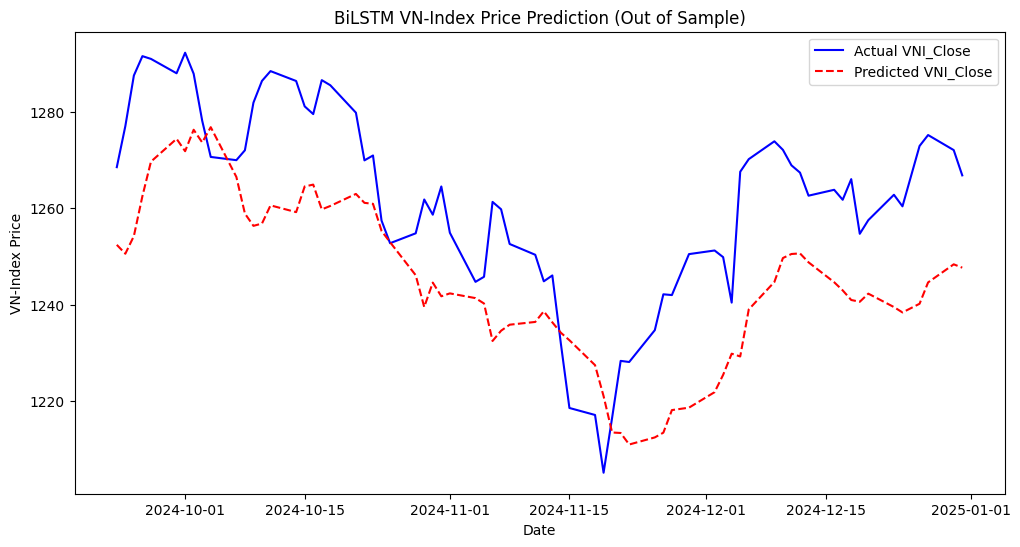

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load dữ liệu OOS
file_path = r"C:\Users\Admin\Downloads\NCKH_\MODEL\Data\data_OOS_2.csv"  # Đổi thành đường dẫn chính xác
df_oos = pd.read_csv(file_path)
df_oos = df_oos[['Date','VNI_Volume','VNI_Close price','VNI_Open price', 'VNI_High price', 'VNI_Low price']]  # Chỉ giữ các cột đã dùng khi train
# Chuyển đổi cột Date thành datetime và đặt làm index
df_oos['Date'] = pd.to_datetime(df_oos['Date'], format="%m/%d/%Y")
df_oos.set_index('Date', inplace=True)

# Xác định cột target và feature
target_col = "VNI_Close price"
feature_cols = [col for col in df_oos.columns if col != target_col]

# Chuẩn hóa dữ liệu OOS
scaler = MinMaxScaler()
df_oos_scaled = pd.DataFrame(scaler.fit_transform(df_oos), columns=df_oos.columns, index=df_oos.index)

# Hàm tạo sequences
def create_sequences(data, seq_length=60):
    sequences, targets = [], []
    data_values = data.values
    for i in range(len(data) - seq_length):
        sequences.append(data_values[i:i + seq_length])
        targets.append(data_values[i + seq_length][data.columns.get_loc(target_col)])
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

# Tạo dữ liệu cho OOS
seq_length = 60
X_oos, y_oos = create_sequences(df_oos_scaled, seq_length)

# Định nghĩa lại mô hình (phải khớp với mô hình đã train)
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        out = self.batchnorm(bilstm_out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

# Load mô hình đã train
input_size = X_oos.shape[2]
model = BiLSTMModel(input_size)
model.load_state_dict(torch.load("bilstm_base.pth", map_location=torch.device("cpu")))
model.eval()

# Dự đoán trên tập OOS theo batch nhỏ để giảm tải bộ nhớ
batch_size = 32
predictions_oos = []

with torch.no_grad():
    for i in range(0, len(X_oos), batch_size):
        batch_X = X_oos[i:i + batch_size]
        y_pred = model(batch_X).cpu().numpy()
        predictions_oos.extend(y_pred)

# Chuyển về giá trị gốc
predictions_oos = np.array(predictions_oos).reshape(-1, 1)
scaler_target = MinMaxScaler()
scaler_target.fit(df_oos[[target_col]])
predictions_oos = scaler_target.inverse_transform(predictions_oos)

# Vẽ biểu đồ Actual vs Predicted OOS
plt.figure(figsize=(12, 6))
plt.plot(df_oos.index[-len(predictions_oos):], df_oos[target_col].iloc[-len(predictions_oos):].values, label="Actual VNI_Close", color='blue')
plt.plot(df_oos.index[-len(predictions_oos):], predictions_oos, label="Predicted VNI_Close", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("VN-Index Price")
plt.title("BiLSTM VN-Index Price Prediction (Out of Sample)")
plt.legend()
plt.show()


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính MSE
mse = mean_squared_error(df_oos[target_col].iloc[-len(predictions_oos):], predictions_oos)

# Tính RMSE
rmse = np.sqrt(mse)

# Tính MAE
mae = mean_absolute_error(df_oos[target_col].iloc[-len(predictions_oos):], predictions_oos)

# Tính MAPE
actual_values = df_oos[target_col].iloc[-len(predictions_oos):].values
mape = np.mean(np.abs((actual_values - predictions_oos.flatten()) / actual_values)) * 100

# In kết quả
print(f"✅ MSE: {mse:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ MAPE: {mape:.2f}%")


✅ MSE: 415.9809
✅ RMSE: 20.3956
✅ MAE: 18.3151
✅ MAPE: 1.45%


In [3]:
# Tạo DataFrame kết quả
results_df = pd.DataFrame({
    "Date": df_oos.index[-len(predictions_oos):],  # Ngày tương ứng với dự đoán
    "Actual": df_oos[target_col].iloc[-len(predictions_oos):].values,  # Giá thực tế
    "Predicted": predictions_oos.flatten()  # Giá dự đoán
})

# Reset index để có cột ngày
results_df.reset_index(inplace=True)

# Đổi tên cột index thành 'Date' nếu chưa có
results_df.rename(columns={"index": "Date"}, inplace=True)

# In bảng kết quả
print(results_df)

# Lưu bảng kết quả ra file CSV (tùy chọn)
results_df.to_csv("bilstm_base_OOS_predictions.csv", index=False)


   Date       Date   Actual    Predicted
0     0 2024-09-23  1268.48  1252.381470
1     1 2024-09-24  1276.99  1250.541626
2     2 2024-09-25  1287.48  1254.199951
3     3 2024-09-26  1291.49  1262.483765
4     4 2024-09-27  1290.92  1269.627686
..  ...        ...      ...          ...
65   65 2024-12-24  1260.36  1238.370728
66   66 2024-12-26  1272.87  1240.167480
67   67 2024-12-27  1275.14  1244.596558
68   68 2024-12-30  1272.02  1248.343628
69   69 2024-12-31  1266.78  1247.649902

[70 rows x 4 columns]


Baseline RMSE: 0.0192


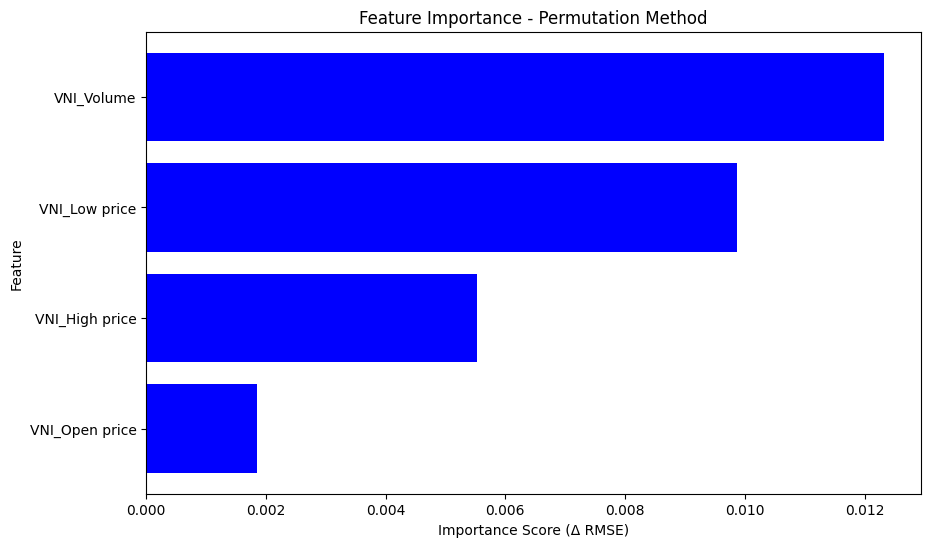

In [9]:
from sklearn.metrics import mean_squared_error
import copy

# Dự đoán ban đầu trên tập test (để lấy baseline RMSE)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    predictions = model(X_test.to(device)).cpu().numpy()
baseline_rmse = np.sqrt(mean_squared_error(y_test.numpy(), predictions))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Tính Feature Importance bằng cách hoán đổi từng feature
feature_importance = {}
for i, feature in enumerate(feature_cols):
    X_test_permuted = X_test.clone()
    np.random.shuffle(X_test_permuted[:, :, i].numpy())  # Xáo trộn feature thứ i

    # Dự đoán lại
    with torch.no_grad():
        permuted_predictions = model(X_test_permuted.to(device)).cpu().numpy()
    
    # Tính RMSE sau khi hoán đổi
    permuted_rmse = np.sqrt(mean_squared_error(y_test.numpy(), permuted_predictions))
    importance_score = permuted_rmse - baseline_rmse  # Feature nào làm tăng RMSE nhiều là quan trọng hơn
    feature_importance[feature] = importance_score

# Sắp xếp theo độ quan trọng giảm dần
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_features], [x[1] for x in sorted_features], color='blue')
plt.xlabel("Importance Score (Δ RMSE)")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Method")
plt.gca().invert_yaxis()  # Đảo ngược để feature quan trọng nhất ở trên cùng
plt.show()


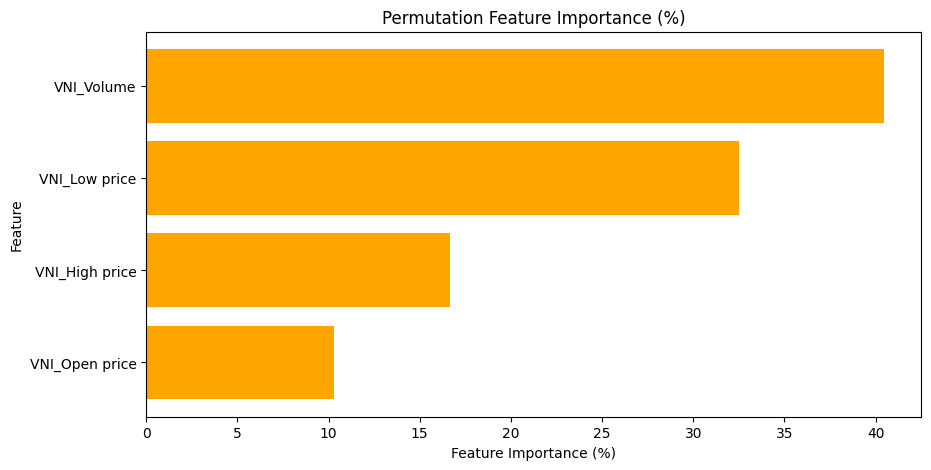

In [10]:
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X_test, y_test, feature_cols, scaler_target):
    baseline_preds = model(X_test.to(device)).cpu().detach().numpy()
    baseline_preds = scaler_target.inverse_transform(baseline_preds.reshape(-1, 1))
    y_test = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1))
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

    importance_scores = {}

    for i, col in enumerate(feature_cols):
        X_test_permuted = X_test.clone()
        permuted_col = X_test_permuted[:, :, i]
        permuted_col[:] = permuted_col[torch.randperm(permuted_col.shape[0])]  # Xáo trộn giá trị cột

        permuted_preds = model(X_test_permuted.to(device)).cpu().detach().numpy()
        permuted_preds = scaler_target.inverse_transform(permuted_preds.reshape(-1, 1))

        permuted_rmse = np.sqrt(mean_squared_error(y_test, permuted_preds))
        importance_scores[col] = permuted_rmse - baseline_rmse  # Chênh lệch RMSE

    # Chuyển đổi sang % importance
    total_importance = sum(importance_scores.values())
    importance_percent = {k: (v / total_importance) * 100 for k, v in importance_scores.items()}

    return importance_percent

# Chạy tính toán importance
X_test_tensor, y_test_tensor = X_test.to(device), y_test.to(device)
feature_importance = permutation_importance(model, X_test_tensor, y_test_tensor, feature_cols, scaler_target)
import matplotlib.pyplot as plt

# Sắp xếp feature importance theo giá trị giảm dần
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance_values = zip(*sorted_importance)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.barh(features, importance_values, color='orange')
plt.xlabel("Feature Importance (%)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance (%)")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để feature quan trọng nhất nằm trên cùng
plt.show()
